In [1]:
import os
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
H, W = 224, 224
BATCH_SIZE = 32
EPOCH = 50

In [3]:
image_paths = []
image_labels = []
normal_count = scc_count = 0

for dirname, _, filenames in os.walk('/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/'):
    for filename in filenames:
        if "bak" in filename: continue    #Ignore all images ending with .bak
        path = os.path.join(dirname, filename)
        image_paths.append(path)
        if 'normal' in filename:
            image_labels.append(0)
            normal_count += 1
        else:
            image_labels.append(1)
            scc_count += 1

#Shuffle
combined = list(zip(image_paths, image_labels))
random.shuffle(combined)
image_paths, image_labels = zip(*combined)
image_paths = list(image_paths)
image_labels = list(image_labels)

print(image_paths[:5], '\n')
print(image_labels[:5], '\n')
print("Image count:", len(image_paths))
print("Normal count:", normal_count)
print("SCC count:", scc_count)
print("Image size:", Image.open(image_paths[0]).size)
print("Image mode:", Image.open(image_paths[0]).mode)

['/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_4843.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_scc/oral_scc_2157.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_normal/oral_normal_4376.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_normal/oral_normal_3070.jpg', '/kaggle/input/multi-cancer/Multi Cancer/Multi Cancer/Oral Cancer/oral_normal/oral_normal_1626.jpg'] 

[1, 1, 0, 0, 0] 

Image count: 10000
Normal count: 5000
SCC count: 5000
Image size: (512, 512)
Image mode: RGB


In [4]:
#train, val, test = 70%, 15%, 15%
train_paths, temp_paths, train_labels, temp_labels = train_test_split(image_paths, image_labels, test_size=0.3, stratify=image_labels)
val_paths, test_paths, val_labels, test_labels = train_test_split(temp_paths, temp_labels, test_size=0.5, stratify=temp_labels)

print("Training size:", len(train_paths))
print("Validation size:", len(val_paths))
print("Testing size:", len(test_paths))

Training size: 7000
Validation size: 1500
Testing size: 1500


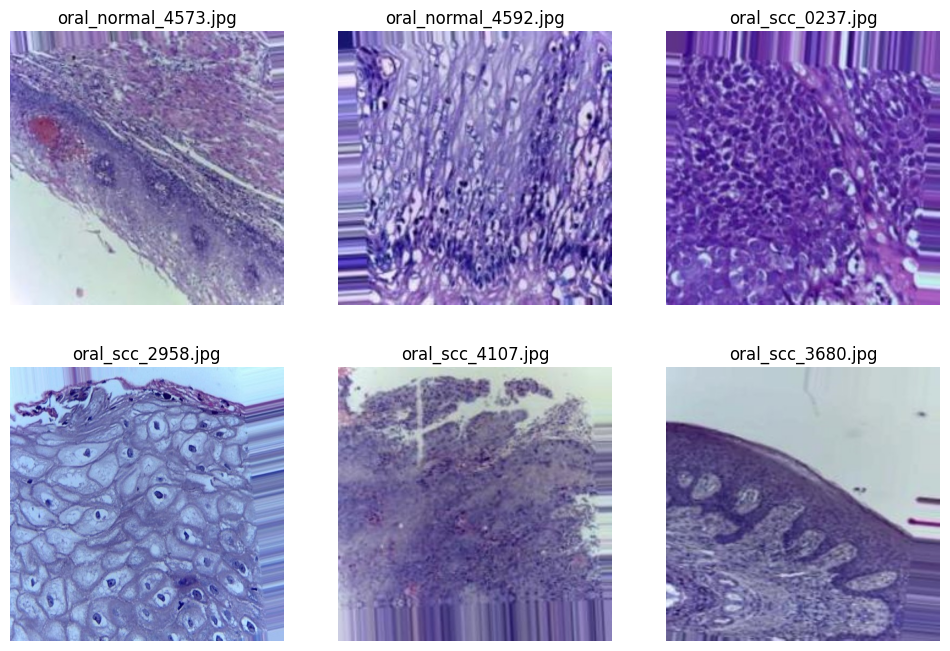

In [5]:
sample_images = random.sample(train_paths, 6)
plt.figure(figsize=(12, 8))

for i, img_path in enumerate(sample_images):
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(os.path.basename(img_path), fontsize=12)
    plt.axis('off')

plt.show()

In [6]:
# Calculate Mean and Standard Deviation of the training set
transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor()
])

mean = 0.
std = 0.
n = 0

for path in tqdm(train_paths):
    img = Image.open(path).convert('RGB')
    img = transform(img)  # shape: [3, H, W]
    mean += img.mean(dim=[1,2])
    std += img.std(dim=[1,2])
    n += 1

mean /= n
std /= n

print("Mean:", mean)
print("Std:", std)

100%|██████████| 7000/7000 [01:00<00:00, 114.89it/s]

Mean: tensor([0.5526, 0.5146, 0.7287])
Std: tensor([0.1620, 0.1929, 0.1226])


In [7]:
#Data augmentation 
train_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

val_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

test_transform = transforms.Compose([
    transforms.Resize((H, W)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

In [8]:
class ImageDataset(Dataset):
    def __init__(self, image_paths, image_labels, transform=None):
        self.image_paths = image_paths
        self.labels = image_labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        return image, label

# For train_loader, val_loader and test_loader
# There are approximately len({}_paths) / BATCH_SIZE batches in total
# Each batch has a shape of [BATCH_SIZE, 3, H, W]
train_dataset = ImageDataset(train_paths, train_labels, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True) 

val_dataset = ImageDataset(val_paths, val_labels, transform=val_transform)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True) 

test_dataset = ImageDataset(test_paths, test_labels, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [9]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models

In [10]:

EPOCH = 25                 # 第一階段的 Epoch 數量

best_model_path = "best_oral_cancer_model.pth"

# 設置 GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


print("Loading ResNet50 model...")
model = models.resnet50(pretrained=True)

# 凍結所有層
for param in model.parameters():
    param.requires_grad = False

# 最後的分類層
num_features = model.fc.in_features 
model.fc = nn.Linear(num_features, 2) # (normal, scc)

model = model.to(device)

# --- Training ---
print("\n--- Training  ---")

criterion = nn.CrossEntropyLoss()

# 優化器 
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

best_val_acc = 0.0

for epoch in range(EPOCH):
    model.train() 
    train_loss = 0.0
    train_corrects = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{EPOCH} [Train]")
    
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        train_pbar.set_postfix({'loss': loss.item()})

    epoch_train_loss = train_loss / len(train_dataset)
    epoch_train_acc = train_corrects.double() / len(train_dataset)

    model.eval() 
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{EPOCH} [Val]")
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_pbar.set_postfix({'loss': loss.item()})


    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_corrects.double() / len(val_dataset)

    print(f"Epoch {epoch+1}/{EPOCH} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
    
    # 儲存最佳模型
    if epoch_val_acc > best_val_acc:
        best_val_acc = epoch_val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f"New best model saved to {best_model_path} with Val Acc: {best_val_acc:.4f}")

print("finished.")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Using device: cuda
Loading ResNet50 model...


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 199MB/s]



--- Starting Phase 1: Training the Head ---


Epoch 1/25 [Val]: 100%|██████████| 47/47 [00:16<00:00,  2.88it/s, loss=0.337]


Epoch 1/25 | Train Loss: 0.5331 Acc: 0.7291 | Val Loss: 0.4667 Acc: 0.7713
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.7713


Epoch 2/25 [Val]: 100%|██████████| 47/47 [00:11<00:00,  4.01it/s, loss=0.557]


Epoch 2/25 | Train Loss: 0.4630 Acc: 0.7824 | Val Loss: 0.4986 Acc: 0.7387


Epoch 3/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.91it/s, loss=0.568]


Epoch 3/25 | Train Loss: 0.4601 Acc: 0.7830 | Val Loss: 0.4385 Acc: 0.8027
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8027


Epoch 4/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.82it/s, loss=0.404]


Epoch 4/25 | Train Loss: 0.4257 Acc: 0.8043 | Val Loss: 0.4261 Acc: 0.8073
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8073


Epoch 5/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s, loss=0.387]


Epoch 5/25 | Train Loss: 0.4298 Acc: 0.8033 | Val Loss: 0.4017 Acc: 0.8140
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8140


Epoch 6/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.87it/s, loss=0.379]


Epoch 6/25 | Train Loss: 0.4118 Acc: 0.8046 | Val Loss: 0.3828 Acc: 0.8273
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8273


Epoch 7/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.86it/s, loss=0.386]


Epoch 7/25 | Train Loss: 0.4233 Acc: 0.8044 | Val Loss: 0.4087 Acc: 0.8180


Epoch 8/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.85it/s, loss=0.529]


Epoch 8/25 | Train Loss: 0.3908 Acc: 0.8211 | Val Loss: 0.3844 Acc: 0.8320
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8320


Epoch 9/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.86it/s, loss=0.434]


Epoch 9/25 | Train Loss: 0.4025 Acc: 0.8139 | Val Loss: 0.3884 Acc: 0.8313


Epoch 10/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.83it/s, loss=0.241]


Epoch 10/25 | Train Loss: 0.3941 Acc: 0.8207 | Val Loss: 0.3753 Acc: 0.8353
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8353


Epoch 11/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.84it/s, loss=0.427]


Epoch 11/25 | Train Loss: 0.3881 Acc: 0.8207 | Val Loss: 0.3643 Acc: 0.8400
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8400


Epoch 12/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.82it/s, loss=0.594]


Epoch 12/25 | Train Loss: 0.3770 Acc: 0.8331 | Val Loss: 0.3493 Acc: 0.8507
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8507


Epoch 13/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.85it/s, loss=0.266]


Epoch 13/25 | Train Loss: 0.3937 Acc: 0.8244 | Val Loss: 0.3549 Acc: 0.8487


Epoch 14/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.74it/s, loss=0.307]


Epoch 14/25 | Train Loss: 0.3925 Acc: 0.8166 | Val Loss: 0.3802 Acc: 0.8273


Epoch 15/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.86it/s, loss=0.342]


Epoch 15/25 | Train Loss: 0.3985 Acc: 0.8166 | Val Loss: 0.3464 Acc: 0.8460


Epoch 16/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.90it/s, loss=0.37] 


Epoch 16/25 | Train Loss: 0.4338 Acc: 0.8053 | Val Loss: 0.3654 Acc: 0.8420


Epoch 17/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.84it/s, loss=0.779]


Epoch 17/25 | Train Loss: 0.3946 Acc: 0.8253 | Val Loss: 0.5720 Acc: 0.7540


Epoch 18/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s, loss=0.465]


Epoch 18/25 | Train Loss: 0.3945 Acc: 0.8257 | Val Loss: 0.3800 Acc: 0.8260


Epoch 19/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.72it/s, loss=0.442]


Epoch 19/25 | Train Loss: 0.3888 Acc: 0.8249 | Val Loss: 0.3533 Acc: 0.8433


Epoch 20/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.66it/s, loss=0.521]


Epoch 20/25 | Train Loss: 0.3767 Acc: 0.8326 | Val Loss: 0.3461 Acc: 0.8580
New best model saved to best_oral_cancer_model.pth with Val Acc: 0.8580


Epoch 21/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.71it/s, loss=0.362]


Epoch 21/25 | Train Loss: 0.3680 Acc: 0.8353 | Val Loss: 0.3817 Acc: 0.8347


Epoch 22/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.71it/s, loss=0.718]


Epoch 22/25 | Train Loss: 0.3650 Acc: 0.8379 | Val Loss: 0.4037 Acc: 0.8240


Epoch 23/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.68it/s, loss=0.256]


Epoch 23/25 | Train Loss: 0.3703 Acc: 0.8374 | Val Loss: 0.3712 Acc: 0.8427


Epoch 24/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.89it/s, loss=0.532]


Epoch 24/25 | Train Loss: 0.3830 Acc: 0.8263 | Val Loss: 0.4138 Acc: 0.7947


Epoch 25/25 [Val]: 100%|██████████| 47/47 [00:12<00:00,  3.87it/s, loss=0.513]

Epoch 25/25 | Train Loss: 0.3727 Acc: 0.8326 | Val Loss: 0.3867 Acc: 0.8280
Phase 1 finished.


In [11]:
# 模型微調 
print("\n--- Fine-Tuning ---")

NUM_FINETUNE_EPOCHS = 20   # 第二階段的 Epoch 數量

# 載入第一階段的最佳模型
model.load_state_dict(torch.load(best_model_path))
print(f"Loaded best model from Phase 1 with Val Acc: {best_val_acc:.4f}")

# 解凍所有層
for param in model.parameters():
    param.requires_grad = True

# 優化器
optimizer = optim.Adam(model.parameters(), lr=1e-5) # 學習率 0.00001

best_finetune_acc = best_val_acc 

for epoch in range(NUM_FINETUNE_EPOCHS):
    model.train()
    train_loss = 0.0
    train_corrects = 0
    train_pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} [Finetune Train]")
    
    for inputs, labels in train_pbar:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * inputs.size(0)
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == labels.data)
        train_pbar.set_postfix({'loss': loss.item()})

    epoch_train_loss = train_loss / len(train_dataset)
    epoch_train_acc = train_corrects.double() / len(train_dataset)


    model.eval()
    val_loss = 0.0
    val_corrects = 0
    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc=f"Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} [Finetune Val]")
        for inputs, labels in val_pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == labels.data)
            val_pbar.set_postfix({'loss': loss.item()})

    epoch_val_loss = val_loss / len(val_dataset)
    epoch_val_acc = val_corrects.double() / len(val_dataset)

    print(f"Epoch {epoch+1}/{NUM_FINETUNE_EPOCHS} | Train Loss: {epoch_train_loss:.4f} Acc: {epoch_train_acc:.4f} | Val Loss: {epoch_val_loss:.4f} Acc: {epoch_val_acc:.4f}")
    
    # 儲存的最佳模型
    if epoch_val_acc > best_finetune_acc:
        best_finetune_acc = epoch_val_acc
        torch.save(model.state_dict(), best_model_path) # 覆蓋掉舊的最佳模型
        print(f"New BEST model saved (Fine-Tuning) to {best_model_path} with Val Acc: {best_finetune_acc:.4f}")

print(" Fine-tuning finished.")




--- Starting Phase 2: Fine-Tuning ---
Loaded best model from Phase 1 with Val Acc: 0.8580


Epoch 1/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.89it/s, loss=0.0652]


Epoch 1/20 | Train Loss: 0.2851 Acc: 0.8756 | Val Loss: 0.2181 Acc: 0.9000
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9000


Epoch 2/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.89it/s, loss=0.178] 


Epoch 2/20 | Train Loss: 0.1736 Acc: 0.9303 | Val Loss: 0.1421 Acc: 0.9440
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9440


Epoch 3/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.89it/s, loss=0.0826]


Epoch 3/20 | Train Loss: 0.1220 Acc: 0.9531 | Val Loss: 0.1154 Acc: 0.9527
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9527


Epoch 4/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.84it/s, loss=0.0327]


Epoch 4/20 | Train Loss: 0.0982 Acc: 0.9650 | Val Loss: 0.0995 Acc: 0.9647
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9647


Epoch 5/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.75it/s, loss=0.0539] 


Epoch 5/20 | Train Loss: 0.0824 Acc: 0.9673 | Val Loss: 0.0749 Acc: 0.9720
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9720


Epoch 6/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.84it/s, loss=0.0268] 


Epoch 6/20 | Train Loss: 0.0628 Acc: 0.9763 | Val Loss: 0.0637 Acc: 0.9767
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9767


Epoch 7/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.76it/s, loss=0.153]  


Epoch 7/20 | Train Loss: 0.0560 Acc: 0.9799 | Val Loss: 0.0647 Acc: 0.9760


Epoch 8/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.85it/s, loss=0.0386] 


Epoch 8/20 | Train Loss: 0.0513 Acc: 0.9817 | Val Loss: 0.0627 Acc: 0.9767


Epoch 9/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.89it/s, loss=0.197]   


Epoch 9/20 | Train Loss: 0.0436 Acc: 0.9847 | Val Loss: 0.0633 Acc: 0.9727


Epoch 10/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.79it/s, loss=0.111]  


Epoch 10/20 | Train Loss: 0.0479 Acc: 0.9813 | Val Loss: 0.0606 Acc: 0.9793
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9793


Epoch 11/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.85it/s, loss=0.0221]  


Epoch 11/20 | Train Loss: 0.0399 Acc: 0.9840 | Val Loss: 0.0603 Acc: 0.9800
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9800


Epoch 12/20 [Finetune Val]: 100%|██████████| 47/47 [00:11<00:00,  3.92it/s, loss=0.00214] 


Epoch 12/20 | Train Loss: 0.0322 Acc: 0.9883 | Val Loss: 0.0522 Acc: 0.9793


Epoch 13/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.80it/s, loss=0.0121]  


Epoch 13/20 | Train Loss: 0.0313 Acc: 0.9879 | Val Loss: 0.0507 Acc: 0.9787


Epoch 14/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.89it/s, loss=0.00197] 


Epoch 14/20 | Train Loss: 0.0360 Acc: 0.9869 | Val Loss: 0.0529 Acc: 0.9833
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9833


Epoch 15/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.84it/s, loss=0.00544] 


Epoch 15/20 | Train Loss: 0.0310 Acc: 0.9879 | Val Loss: 0.0518 Acc: 0.9800


Epoch 16/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.78it/s, loss=0.0829]  


Epoch 16/20 | Train Loss: 0.0287 Acc: 0.9883 | Val Loss: 0.0484 Acc: 0.9820


Epoch 17/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.86it/s, loss=0.000747]


Epoch 17/20 | Train Loss: 0.0238 Acc: 0.9913 | Val Loss: 0.0544 Acc: 0.9833


Epoch 18/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.80it/s, loss=0.00248] 


Epoch 18/20 | Train Loss: 0.0231 Acc: 0.9919 | Val Loss: 0.0401 Acc: 0.9853
New BEST model saved (Fine-Tuning) to best_oral_cancer_model.pth with Val Acc: 0.9853


Epoch 19/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.81it/s, loss=0.00236] 


Epoch 19/20 | Train Loss: 0.0281 Acc: 0.9883 | Val Loss: 0.0497 Acc: 0.9840


Epoch 20/20 [Finetune Val]: 100%|██████████| 47/47 [00:12<00:00,  3.86it/s, loss=0.0795]  

Epoch 20/20 | Train Loss: 0.0245 Acc: 0.9909 | Val Loss: 0.0464 Acc: 0.9807
Phase 2 (Fine-tuning) finished.


In [12]:
# 最終測試
print("\n--- Final Testing ---")

# 載入表現最好的模型
model.load_state_dict(torch.load(best_model_path))
model.eval() 

test_corrects = 0
test_total = 0

with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc="Testing"):
        inputs, labels = inputs.to(device), labels.to(device)
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        test_corrects += torch.sum(preds == labels.data)
        test_total += labels.size(0)

final_test_acc = test_corrects.double() / test_total
print(f"Final Test Accuracy on {test_total} images: {final_test_acc:.4f}")



--- Starting Final Testing ---


Testing: 100%|██████████| 47/47 [00:18<00:00,  2.59it/s]

Final Test Accuracy on 1500 images: 0.9887
